In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB  # For continuous features
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

In [4]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Uploads/3-Senior_Apu_heart.csv')
#df = pd.read_csv('3-Senior_Apu_heart.csv')
script_dir = os.path.dirname(os.path.abspath(__file__))
csv_path = os.path.join(script_dir, '3-Senior_Apu_heart.csv')

df = pd.read_csv(csv_path)
# df = df.drop(columns=['id'])  # Drop the 'id' column
df.head()

,age,sex,bmi,cp,trestbps,chol,fbs,diabetes,maxHR,smoker,target
0,52,1,36,0,125,212,0,0,172,2,1
1,53,1,32,0,140,203,1,0,156,1,1
2,70,1,32,0,145,174,0,0,98,0,1
3,61,1,34,0,148,203,0,0,108,2,1
4,62,0,24,0,138,294,1,0,122,0,0


In [5]:
num_rows, num_cols = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 776
Number of columns: 11


In [6]:
# Drop duplicates
df.drop_duplicates(inplace=True)

In [7]:
# Check for constant columns
df.nunique()

age          41
sex           2
bmi          41
cp            4
trestbps     49
chol        152
fbs           2
diabetes      2
maxHR       116
smoker        3
target        2
dtype: int64

In [8]:
num_rows, num_cols = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 776
Number of columns: 11


In [9]:
# Check for null values
null_values = df.isnull().sum()
print("Null values in each column:\n", null_values)
#df.fillna(df.median(), inplace=True)  # Fill missing numerical values with median

Null values in each column:
 age         0
sex         0
bmi         0
cp          0
trestbps    0
chol        0
fbs         0
diabetes    0
maxHR       0
smoker      0
target      0
dtype: int64


In [10]:
# Find rows with any negative value
negative_rows = df[(df < 0).any(axis=1)]

# Remove rows with negative values
df = df[~(df < 0).any(axis=1)]

num_rows, num_cols = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 776
Number of columns: 11


In [11]:
for column in df.columns:
    min_value = df[column].min()
    max_value = df[column].max()
    print(f"Column: {column}")
    print(f"  Minimum: {min_value}")
    print(f"  Maximum: {max_value}")
    print("-" * 20)  # Add a separator for better readability

Column: age
  Minimum: 29
  Maximum: 77
--------------------
Column: sex
  Minimum: 0
  Maximum: 1
--------------------
Column: bmi
  Minimum: 14
  Maximum: 65
--------------------
Column: cp
  Minimum: 0
  Maximum: 3
--------------------
Column: trestbps
  Minimum: 94
  Maximum: 200
--------------------
Column: chol
  Minimum: 126
  Maximum: 564
--------------------
Column: fbs
  Minimum: 0
  Maximum: 1
--------------------
Column: diabetes
  Minimum: 0
  Maximum: 1
--------------------
Column: maxHR
  Minimum: 60
  Maximum: 195
--------------------
Column: smoker
  Minimum: 0
  Maximum: 2
--------------------
Column: target
  Minimum: 0
  Maximum: 1
--------------------


In [12]:
# Function to detect outliers
def detect_outliers(df, column, low, up):

    # Identify outliers
    outliers = df[(df[column] < low) | (df[column] > up)].index.tolist()

    return outliers

In [13]:
# Check for outliers in specific column
all_outliers = []

outliers_age = detect_outliers(df, 'age', 10, 100)
print(f"{len(outliers_age)} Outliers in age:\n", outliers_age)
all_outliers.extend(outliers_age)

outliers_sex = detect_outliers(df, 'sex', 0, 1)
print(f"{len(outliers_sex)} Outliers in sex:\n", outliers_sex)
all_outliers.extend(outliers_sex)

outliers_bmi = detect_outliers(df, 'bmi', 14, 55)
print(f"{len(outliers_bmi)} Outliers in bmi:\n", outliers_bmi)
all_outliers.extend(outliers_bmi)

outliers_cp = detect_outliers(df, 'cp', 0, 2)
print(f"{len(outliers_cp)} Outliers in cp:\n", outliers_cp)
all_outliers.extend(outliers_cp)

outliers_trestbps = detect_outliers(df, 'trestbps', 90, 200)
print(f"{len(outliers_trestbps)} Outliers in resting bp s:\n", outliers_trestbps)
all_outliers.extend(outliers_trestbps)

outliers_chol = detect_outliers(df, 'chol', 50, 600)
print(f"{len(outliers_chol)} Outliers in chol:\n", outliers_chol)
all_outliers.extend(outliers_chol)

outliers_fbs = detect_outliers(df, 'fbs', 0, 1)
print(f"{len(outliers_fbs)} Outliers in fasting blood sugar:\n", outliers_fbs)
all_outliers.extend(outliers_fbs)

outliers_diabetes = detect_outliers(df, 'diabetes', 0, 1)
print(f"{len(outliers_diabetes)} Outliers in resting ecg:\n", outliers_diabetes)
all_outliers.extend(outliers_diabetes)

outliers_maxHR = detect_outliers(df, 'maxHR', 60, 200)
print(f"{len(outliers_maxHR)} Outliers in max heart rate:\n", outliers_maxHR)
all_outliers.extend(outliers_maxHR)

outliers_smoker = detect_outliers(df, 'smoker', 0, 2)
print(f"{len(outliers_smoker)} Outliers in aexercise angina:\n", outliers_smoker)
all_outliers.extend(outliers_smoker)

# Drop the outlier rows
df_cleaned = df.drop(all_outliers)

0 Outliers in age:
 []
0 Outliers in sex:
 []
5 Outliers in bmi:
 [113, 270, 358, 577, 734]
52 Outliers in cp:
 [36, 50, 56, 65, 104, 125, 130, 142, 143, 148, 156, 181, 193, 201, 202, 203, 205, 222, 235, 258, 283, 314, 315, 358, 379, 389, 391, 399, 414, 455, 462, 470, 528, 529, 539, 543, 572, 576, 585, 623, 624, 627, 628, 629, 630, 638, 652, 664, 709, 713, 714, 763]
0 Outliers in resting bp s:
 []
0 Outliers in chol:
 []
0 Outliers in fasting blood sugar:
 []
0 Outliers in resting ecg:
 []
0 Outliers in max heart rate:
 []
0 Outliers in aexercise angina:
 []


In [14]:
def detect_all_outliers_iqr(df):
    """
    Detects outliers in all specified numerical columns of a Pandas DataFrame
    using the IQR method.

    Args:
        data: Pandas DataFrame containing the data.
        numerical_cols: A list of column names representing the numerical features.

    Returns:
        A list of all outlier indices in the DataFrame.
    """
    all_outliers = []
    numerical_cols = ['ap_hi', 'ap_lo']
    for col in numerical_cols:
        # Calculate quartiles
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate upper and lower bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers for the current column
        outliers_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()

        # Print information about outliers in the current column
        print(f"{len(outliers_col)} Outliers in {col}:\n", outliers_col)

        # Extend the list of all outliers
        all_outliers.extend(outliers_col)

    # Remove duplicates from the list of all outliers
    all_outliers = list(set(all_outliers))

    # Drop the outlier rows
    df_cleaned = df.drop(all_outliers)

    return df_cleaned

In [15]:
# For 'ap_hi', 'ap_lo' only
# df_cleaned = detect_all_outliers_iqr(df_cleaned)

In [16]:
num_rows, num_cols = df_cleaned.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 720
Number of columns: 11


In [17]:
# Check for constant columns
df_cleaned.nunique()

age          41
sex           2
bmi          38
cp            3
trestbps     49
chol        150
fbs           2
diabetes      2
maxHR       114
smoker        3
target        2
dtype: int64

In [18]:
# Calculate BMI and add it as a new column
# df_cleaned['bmi'] = df_cleaned['weight'] / ((df_cleaned['height'] / 100) ** 2)  # height in cm, weight in kg

In [19]:
# Calculate MAP and add it as a new column
# df_cleaned['map'] = (2 * df_cleaned['ap_lo'] + df_cleaned['ap_hi']) / 3

In [20]:
df_cleaned.head()

,age,sex,bmi,cp,trestbps,chol,fbs,diabetes,maxHR,smoker,target
0,52,1,36,0,125,212,0,0,172,2,1
1,53,1,32,0,140,203,1,0,156,1,1
2,70,1,32,0,145,174,0,0,98,0,1
3,61,1,34,0,148,203,0,0,108,2,1
4,62,0,24,0,138,294,1,0,122,0,0


In [21]:
# df_cleaned = df_cleaned.drop(['height', 'weight', 'ap_lo', 'ap_hi'], axis=1)

In [22]:
# column_names = list(df_cleaned.columns)
# column_names.insert(1, column_names[8])  # Insert 'bmi' at 2rd position
# column_names.insert(2, column_names[10]) # Insert 'map' at 3rd position
# column_names = column_names[:-2] #remove tha last two columns
# df_cleaned = df_cleaned[column_names]

In [23]:
# df_cleaned.head()

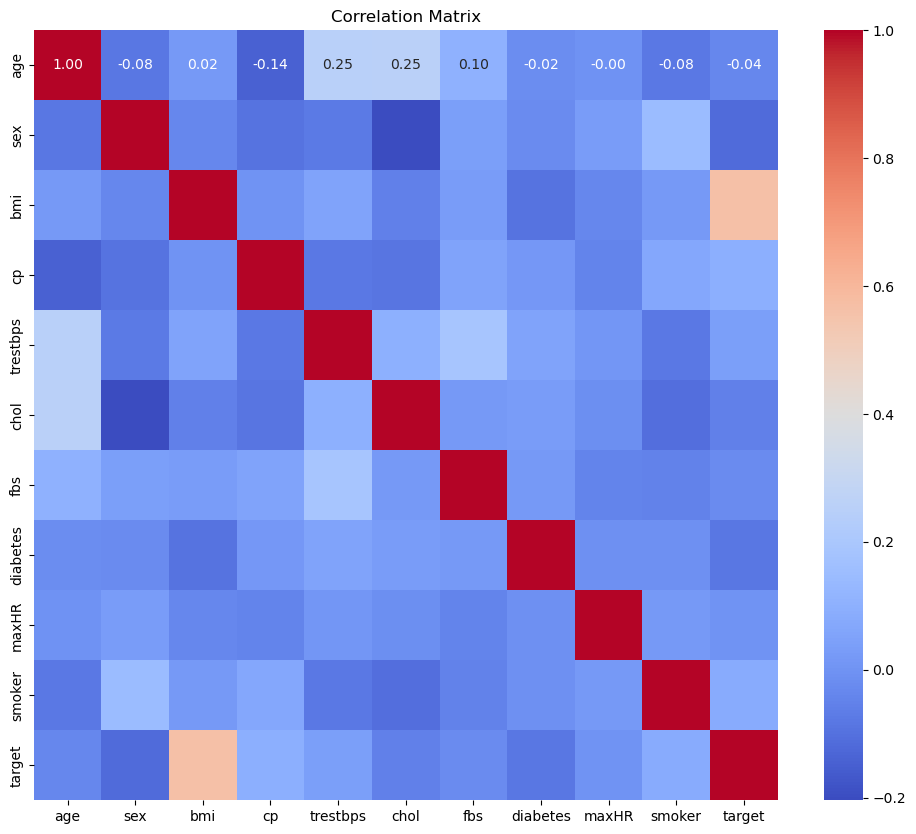

In [24]:
# Feature Selection
plt.figure(figsize=(12, 10))
sns.heatmap(df_cleaned.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [25]:
def correlation(df, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [26]:
corr_features = correlation(df_cleaned, 0.7)
print(f"{len(corr_features)} Correlated features detected:\n", corr_features)

0 Correlated features detected:
 set()


In [27]:
df_cleaned.head()

,age,sex,bmi,cp,trestbps,chol,fbs,diabetes,maxHR,smoker,target
0,52,1,36,0,125,212,0,0,172,2,1
1,53,1,32,0,140,203,1,0,156,1,1
2,70,1,32,0,145,174,0,0,98,0,1
3,61,1,34,0,148,203,0,0,108,2,1
4,62,0,24,0,138,294,1,0,122,0,0


In [28]:
# Apply normalization using StandardScaler
numerical_features = ['age', 'bmi', 'trestbps', 'chol', 'maxHR']
categorical_features = ['sex', 'cp', 'fbs', 'diabetes', 'smoker', 'target']
scaler = StandardScaler()
df_num = pd.DataFrame(scaler.fit_transform(df_cleaned[numerical_features]), columns=numerical_features, index=df_cleaned.index)
df_cat = pd.DataFrame(df_cleaned[categorical_features], columns=categorical_features, index=df_cleaned.index)
df_processed = pd.concat([df_num, df_cat], axis=1)
# df_cleaned[column_names] = scaler.fit_transform(df_cleaned[column_names])

In [29]:
df_processed.head()

,age,bmi,trestbps,chol,maxHR,sex,cp,fbs,diabetes,smoker,target
0,-0.251412,0.969874,-0.352114,-0.676635,1.482203,1,0,0,0,2,1
1,-0.142234,0.363044,0.497681,-0.842385,0.855391,1,0,1,0,1,1
2,1.713785,0.363044,0.780946,-1.376469,-1.416801,1,0,0,0,0,1
3,0.731186,0.666459,0.950905,-0.842385,-1.025044,1,0,0,0,2,1
4,0.840364,-0.850615,0.384375,0.833535,-0.476584,0,0,1,0,0,0


In [30]:
# Preprocess Data
X = df_processed.drop('target', axis=1)
y = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Top features
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X, y)
# SCORE_COL = pd.DataFrame(selector.scores_,columns = ['score value'])
# PVALUE_COL = pd.DataFrame(selector.pvalues_,columns = ['p_value'])

print("Top features:")
# Get scores and selected feature names
scores = selector.scores_
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask]
selected_scores = scores[selected_mask]

# Print feature names with their scores
for feature, score in zip(selected_features, selected_scores):
    print(f"{feature}: {score:.4f}")

Top features:
age: 0.9543
bmi: 333.7162
trestbps: 1.0791
chol: 2.1357
maxHR: 0.0000
sex: 9.9764
cp: 6.5841
fbs: 0.4552
diabetes: 5.2848
smoker: 4.8441


In [32]:
df_processed = df_processed.drop(['maxHR', 'fbs'], axis=1)

In [33]:
# Check for constant columns
df_processed.nunique()

age          41
bmi          38
trestbps     49
chol        150
sex           2
cp            3
diabetes      2
smoker        3
target        2
dtype: int64

In [34]:
# Encode categorical features
numerical_features = ['age', 'bmi', 'trestbps', 'chol']
categorical_features = ['sex', 'cp', 'diabetes', 'smoker']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for DataFrame output
df_cat = pd.DataFrame(encoder.fit_transform(df_processed[categorical_features]), columns=encoder.get_feature_names_out(categorical_features), index=df_processed.index)
df_num = pd.DataFrame(df_processed[numerical_features], columns=numerical_features, index=df_processed.index)
df_processed_encode = pd.concat([df_num, df_cat], axis=1)

In [35]:
df_processed_encode.head()

,age,bmi,trestbps,chol,sex_0,sex_1,cp_0,cp_1,cp_2,diabetes_0,diabetes_1,smoker_0,smoker_1,smoker_2
0,-0.251412,0.969874,-0.352114,-0.676635,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.142234,0.363044,0.497681,-0.842385,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.713785,0.363044,0.780946,-1.376469,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.731186,0.666459,0.950905,-0.842385,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.840364,-0.850615,0.384375,0.833535,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [65]:
df_processed_encode.columns

Index(['age', 'bmi', 'trestbps', 'chol', 'sex_0', 'sex_1', 'cp_0', 'cp_1',
       'cp_2', 'diabetes_0', 'diabetes_1', 'smoker_0', 'smoker_1', 'smoker_2'],
      dtype='object')

In [36]:
# Preprocess Data
X = df_processed_encode
y = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Train the model with SVM Model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [38]:
# Train the model with RandomForest Model
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# Train the model with KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)  # (number of neighbors to consider)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [40]:
# Train the model with Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [41]:
# Train the model with Logistic Regression Model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [42]:
# Train the model with Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [43]:
# Train the model with MLP Model
mlp_model = MLPClassifier(hidden_layer_sizes=(100), random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)

c:\Users\shahs_snohmej\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=100, max_iter=300, random_state=42)

In [44]:
# Train the model with  XGBoost Model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [45]:
# Make Predictions and Evaluate
def predict_and_evaluate(models):
  for model_name, model in models.items():
      y_pred = model.predict(X_test)  # Predict on the test set

      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)

      print(f"Metrics for {model_name}:")
      print(f"  Accuracy: {accuracy}")
      print(f"  Precision: {precision}")
      print(f"  Recall: {recall}")
      print(f"  F1 Score: {f1}")
      print("-" * 20)  # Separator for better readability

In [46]:
models = {
      "SVM": svm_model,
      "RF": RF_model,
      "KNN": knn_model,
      "DT": dt_model,
      "LR": logreg_model,
      "Naive Bayes": nb_model,
      "MLP": mlp_model,
      "XGBoost": xgb_model
  }

predict_and_evaluate(models)

Metrics for SVM:
  Accuracy: 0.8194444444444444
  Precision: 0.9294117647058824
  Recall: 0.797979797979798
  F1 Score: 0.8586956521739131
--------------------
Metrics for RF:
  Accuracy: 0.7708333333333334
  Precision: 0.9230769230769231
  Recall: 0.7272727272727273
  F1 Score: 0.8135593220338984
--------------------
Metrics for KNN:
  Accuracy: 0.7569444444444444
  Precision: 0.872093023255814
  Recall: 0.7575757575757576
  F1 Score: 0.8108108108108109
--------------------
Metrics for DT:
  Accuracy: 0.7569444444444444
  Precision: 0.8636363636363636
  Recall: 0.7676767676767676
  F1 Score: 0.8128342245989305
--------------------
Metrics for LR:
  Accuracy: 0.8194444444444444
  Precision: 0.9294117647058824
  Recall: 0.797979797979798
  F1 Score: 0.8586956521739131
--------------------
Metrics for Naive Bayes:
  Accuracy: 0.75
  Precision: 0.7692307692307693
  Recall: 0.9090909090909091
  F1 Score: 0.8333333333333333
--------------------
Metrics for MLP:
  Accuracy: 0.777777777777777

In [47]:
param_distributions = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC()
svm_best = RandomizedSearchCV(estimator=svm, param_distributions=param_distributions, n_iter=10, cv=5, scoring='accuracy', random_state=42)
svm_best.fit(X_train, y_train)
# best_svm = grid_search.best_estimator_
params_best = svm_best.best_params_

print("Best SVM Hyperparameters:", params_best)

y_pred = svm_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy: {accuracy}")

Best SVM Hyperparameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 100}
  Accuracy: 0.8194444444444444


In [48]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier()
# Use RandomizedSearchCV with a smaller number of iterations:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1)
rf_random.fit(X_train, y_train)
# best_rf = grid_search.best_estimator_
params_random = rf_random.best_params_

print("Best RF Hyperparameters:", params_random)

y_pred = rf_random.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy: {accuracy}")

Best RF Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
  Accuracy: 0.8125


In [49]:
param_distributions = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
knn_best = RandomizedSearchCV(estimator=knn, param_distributions=param_distributions, n_iter=10, cv=5, scoring='accuracy', random_state=42)  # Specify n_iter and random_state
knn_best.fit(X_train, y_train)
# best_knn = grid_search.best_estimator_
params_best = knn_best.best_params_

print("Best KNN Hyperparameters:", params_best)

y_pred = knn_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy: {accuracy}")

Best KNN Hyperparameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 9}
  Accuracy: 0.7986111111111112


In [50]:
param_distributions = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier()
dt_best = RandomizedSearchCV(estimator=dt, param_distributions=param_distributions, n_iter=10, cv=5, scoring='accuracy', random_state=42)
dt_best.fit(X_train, y_train)
# best_dt = grid_search.best_estimator_
params_best = dt_best.best_params_

print("Best DT Hyperparameters:", params_best)

y_pred = dt_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy: {accuracy}")

Best DT Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30, 'criterion': 'gini'}
  Accuracy: 0.7361111111111112


In [51]:
param_distributions = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']
}

lr = LogisticRegression()
lr_best = RandomizedSearchCV(estimator=lr, param_distributions=param_distributions, n_iter=10, cv=5, scoring='accuracy', random_state=42)
lr_best.fit(X_train, y_train)
# best_lr = grid_search.best_estimator_
params_best = lr_best.best_params_

print("Best LR Hyperparameters:", params_best)

y_pred = lr_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy: {accuracy}")

c:\Users\shahs_snohmej\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shahs_snohmej\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shahs_snohmej\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shahs_snohmej\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shahs_snohmej\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\shahs_snohmej\anaconda3\Lib\site-packages\sklearn\linear_mode

Best LR Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
  Accuracy: 0.8263888888888888


c:\Users\shahs_snohmej\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [52]:
param_distributions = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

nb = GaussianNB()
nb_best = RandomizedSearchCV(estimator=nb, param_distributions=param_distributions, n_iter=4, cv=5, scoring='accuracy', random_state=42)
nb_best.fit(X_train, y_train)
# best_nb = grid_search.best_estimator_
params_best = nb_best.best_params_

print("Best NB Hyperparameters:", params_best)

y_pred = nb_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy: {accuracy}")

Best NB Hyperparameters: {'var_smoothing': 1e-09}
  Accuracy: 0.75


In [53]:
# param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#     'activation': ['relu', 'tanh', 'logistic'],
#     'solver': ['adam', 'sgd'],
#     'alpha': [0.0001, 0.001, 0.01]
# }

# mlp = MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=500)
# mlp_best = RandomizedSearchCV(estimator=mlp, param_distributions=param_grid, cv=5, scoring='accuracy')
# mlp_best.fit(X_train, y_train)
# # best_mlp = grid_search.best_estimator_
# params_best = mlp_best.best_params_

# print("Best MLP Hyperparameters:", params_best)

# y_pred = mlp_best.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"  Accuracy: {accuracy}")

In [54]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=5, scoring='accuracy')
xgb_random.fit(X_train, y_train)
# best_xgb = grid_search.best_estimator_
params_best = xgb_random.best_params_

print("Best XGB Hyperparameters:", params_best)

y_pred = xgb_random.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy: {accuracy}")

# print("Classification Report:\n", classification_report(y_test, y_pred))

Best XGB Hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
  Accuracy: 0.8055555555555556


In [55]:
models = {
      "SVM": svm_best,
      "RF": rf_random,
      "KNN": knn_best,
      "DT": dt_best,
      "LR": lr_best,
      "Naive Bayes": nb_best,
      # "MLP": mlp_model,
      "XGBoost": xgb_random
  }

print("### After Hyperparameter tuning:")
predict_and_evaluate(models)

### After Hyperparameter tuning:
Metrics for SVM:
  Accuracy: 0.8194444444444444
  Precision: 0.9294117647058824
  Recall: 0.797979797979798
  F1 Score: 0.8586956521739131
--------------------
Metrics for RF:
  Accuracy: 0.8125
  Precision: 0.9285714285714286
  Recall: 0.7878787878787878
  F1 Score: 0.8524590163934426
--------------------
Metrics for KNN:
  Accuracy: 0.7986111111111112
  Precision: 0.9069767441860465
  Recall: 0.7878787878787878
  F1 Score: 0.8432432432432431
--------------------
Metrics for DT:
  Accuracy: 0.7361111111111112
  Precision: 0.8860759493670886
  Recall: 0.7070707070707071
  F1 Score: 0.7865168539325842
--------------------
Metrics for LR:
  Accuracy: 0.8263888888888888
  Precision: 0.9302325581395349
  Recall: 0.8080808080808081
  F1 Score: 0.8648648648648648
--------------------
Metrics for Naive Bayes:
  Accuracy: 0.75
  Precision: 0.7692307692307693
  Recall: 0.9090909090909091
  F1 Score: 0.8333333333333333
--------------------
Metrics for XGBoost:
  

# Store & Load Model

In [56]:
model_filename_lr = 'logreg_model.pkl'
joblib.dump(lr_best, model_filename_lr)

['logreg_model.pkl']

In [57]:
# Load a model from the file
loaded_lr_model = joblib.load('logreg_model.pkl')

# Now you can use the loaded model for predictions
# For example:
y_pred = loaded_lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"  Accuracy: {accuracy}")

  Accuracy: 0.8263888888888888


# ANN

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [59]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # .values to get NumPy array
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [60]:
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

input_size = X_train.shape[1]
model = ANN(input_size)

In [61]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

In [62]:
# Train the Model
num_epochs = 50

for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Reset gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target.unsqueeze(1))  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

In [63]:
def predict_and_evaluate_ANN(models):
    for model_name, model in models.items():
        if isinstance(model, nn.Module):  # Check if it's a PyTorch model
            model.eval()  # Set to evaluation mode
            with torch.no_grad():
                y_pred = []
                for data, _ in test_loader:
                    output = model(data)
                    predicted = (output > 0.5).float()
                    y_pred.extend(predicted.squeeze().tolist())
            y_pred = torch.tensor(y_pred)
        else:  # Assume it's a scikit-learn model
            y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Metrics for {model_name}:")
        print(f"  Accuracy: {accuracy}")
        print(f"  Precision: {precision}")
        print(f"  Recall: {recall}")
        print(f"  F1 Score: {f1}")
        print("-" * 20)

In [64]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    correct = 0
    total = 0
    for data, target in test_loader:
        output = model(data)
        predicted = (output > 0.5).float()  # Threshold for binary classification
        total += target.size(0)
        correct += (predicted == target.unsqueeze(1)).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    predict_and_evaluate_ANN({"ANN": model})

Test Accuracy: 79.17%
Metrics for ANN:
  Accuracy: 0.7916666666666666
  Precision: 0.9367088607594937
  Recall: 0.7474747474747475
  F1 Score: 0.8314606741573033
--------------------
